# Notebook 04 — Two-Venue Latency Arbitrage Stress Study

This notebook models the economics of a **cross-venue statistical arbitrage** strategy and stress-tests it against the two most important operational frictions:

| Friction | Symbol | Effect |
|----------|--------|--------|
| **Signal latency** | `latency_steps` | Delay between observing a price discrepancy and having your order filled |
| **Transfer delay** | `transfer_delay` | Cooldown before the next trade can be entered (inventory transfer, margin settlement) |

The central question is: **how fast do you need to be, and how quickly does your edge decay?**

**Sections**
| # | Topic |
|---|-------|
| 1 | Construct two synthetic venue mid prices with a mean-reverting cross-venue basis |
| 2 | Define the arbitrage policy: signal, execution, and cooldown logic |
| 3 | Baseline run and equity curve |
| 4 | Stress grid: PnL heatmap across latency × transfer-delay |
| 5 | One-dimensional slices and threshold sensitivity |

> **Scope:** This is a stylised stress-test, not a production HFT simulator. A production system would model queue position, co-location, network topology, and order-level timestamps.

## How to use this notebook

1. Ensure `outputs/baseline_mm_result.json` exists:
   ```bash
   make report
   # or manually:
   PYTHONPATH=src python scripts/run_backtest.py \
       --config configs/baseline_mm.json \
       --output outputs/baseline_mm_result.json
   ```
2. **Run All Cells** top-to-bottom.
3. Edit the parameters cell to test different latency regimes.

### Papermill parameterisation
```bash
papermill notebooks/04_two_venue_latency_arb_analysis.ipynb outputs/nb04_run.ipynb \
    -p result_json ../outputs/baseline_mm_result.json \
    -p baseline_latency 2 \
    -p baseline_transfer_delay 10 \
    -p arb_threshold 0.10
```

In [1]:
# ── Parameters (papermill injection point) ────────────────────────────────
result_json             = '../outputs/baseline_mm_result.json'

# Venue construction
BASIS_KAPPA             = 0.08    # mean-reversion speed of cross-venue basis
BASIS_SHOCK_VOL         = 0.01    # per-step basis shock volatility
VENUE_NOISE_VOL         = 0.03    # independent mid noise on each venue
SPREAD_A_BASE           = 0.04    # venue A bid-ask half-spread (price units)
SPREAD_B_BASE           = 0.05    # venue B bid-ask half-spread
RANDOM_SEED             = 21

# Strategy parameters
arb_threshold           = 0.12    # trigger threshold on |B_mid - A_mid|
fee_bps                 = 2.0     # one-way taker fee (bps)
qty                     = 1.0     # fixed trade size

# Baseline run parameters
baseline_latency        = 1       # signal-to-fill latency (steps)
baseline_transfer_delay = 5       # cooldown steps after each trade

# Stress-grid ranges
LATENCIES               = [0, 1, 2, 3, 5, 8]
DELAYS                  = [1, 3, 5, 10, 20, 40]
THRESHOLDS              = [0.06, 0.08, 0.10, 0.12, 0.16, 0.20]

In [2]:
from __future__ import annotations

import json
import random
import math
from pathlib import Path

import matplotlib.pyplot as plt

result_path = Path(result_json)
if not result_path.exists():
    raise FileNotFoundError(
        f'Missing {result_json}. Run `make report` first.'
    )

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

base_mid = payload['series']['mid']
n        = len(base_mid)

print(f'Loaded {n} steps of base mid data.')
print(f'Mid range: [{min(base_mid):.4f}, {max(base_mid):.4f}]')

Loaded 2500 steps of base mid data.
Mid range: [98.7741, 103.6661]


## 1) Two-venue market construction

### Why mids differ across venues

Even for the same underlying asset, venue mids diverge because:
1. **Stochastic cross-venue basis**: different order flows, liquidity pools, and hedger behaviour create a persistent but mean-reverting price difference.
2. **Independent noise**: each venue's mid has its own microstructure noise (bid-ask bounce, queue effects).
3. **Spread asymmetry**: venue B may be less liquid, with a wider bid-ask spread.

### Our synthetic model

```
basis(t+1) = basis(t) − κ · basis(t) + σ_basis · Z₁
midA(t)    = base_mid(t) + σ_noise · Z₂
midB(t)    = base_mid(t) + basis(t) + σ_noise · Z₃
```

The cross-venue difference `midB − midA` inherits the mean-reverting basis plus independent noise. The arbitrage opportunity exists only while `|midB − midA| > threshold + 2 × fee_cost`.

### Spread (cost to cross)

Each venue has its own bid-ask half-spread. To buy on venue A and sell on venue B, the effective cost is:

```
execution_cost = spread_A + spread_B + 2 × fee_bps × mid / 10000
```

This sets a **natural lower bound** on the profitable threshold.

Cross-venue diff  mean: 0.00518   std: 0.05013
Steps with |diff| >= threshold (0.12): 1.7%


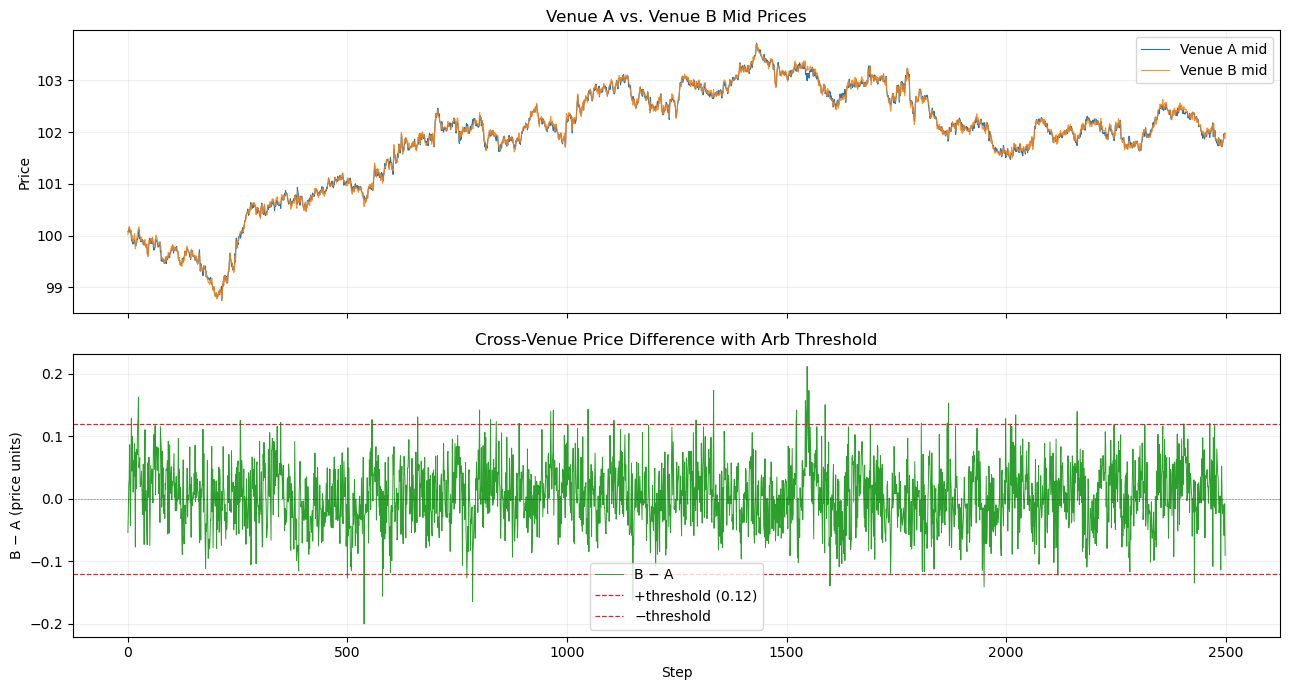

In [3]:
rng     = random.Random(RANDOM_SEED)
venue_a = []
venue_b = []
spread_a = []
spread_b = []

basis = 0.0
for m in base_mid:
    basis += -BASIS_KAPPA * basis + rng.gauss(0.0, BASIS_SHOCK_VOL)
    pa = m + rng.gauss(0.0, VENUE_NOISE_VOL)
    pb = m + basis + rng.gauss(0.0, VENUE_NOISE_VOL)
    venue_a.append(pa)
    venue_b.append(pb)
    spread_a.append(SPREAD_A_BASE + abs(rng.gauss(0.0, 0.01)))
    spread_b.append(SPREAD_B_BASE + abs(rng.gauss(0.0, 0.01)))

diff = [b - a for a, b in zip(venue_a, venue_b)]
avg_diff = sum(diff) / len(diff)
pct_above_thr = sum(1 for d in diff if abs(d) >= arb_threshold) / n * 100

print(f'Cross-venue diff  mean: {avg_diff:.5f}   std: {math.sqrt(sum((d-avg_diff)**2 for d in diff)/n):.5f}')
print(f'Steps with |diff| >= threshold ({arb_threshold}): {pct_above_thr:.1f}%')

fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)
axes[0].plot(venue_a, label='Venue A mid', color='tab:blue', lw=0.8)
axes[0].plot(venue_b, label='Venue B mid', color='tab:orange', lw=0.8, alpha=0.85)
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(alpha=0.2)
axes[0].set_title('Venue A vs. Venue B Mid Prices')

axes[1].plot(diff, color='tab:green', lw=0.7, label='B − A')
axes[1].axhline( arb_threshold, color='tab:red',   linestyle='--', lw=0.9,
                 label=f'+threshold ({arb_threshold})')
axes[1].axhline(-arb_threshold, color='tab:red',   linestyle='--', lw=0.9,
                 label=f'−threshold')
axes[1].axhline(0, color='black', lw=0.4, linestyle=':')
axes[1].set_ylabel('B − A (price units)')
axes[1].set_xlabel('Step')
axes[1].legend()
axes[1].grid(alpha=0.2)
axes[1].set_title('Cross-Venue Price Difference with Arb Threshold')

plt.tight_layout()
plt.show()

## 2) Arbitrage policy definition

### Signal, latency, and execution model

Real latency arbitrage operates on a loop:

```
1. Observe prices on both venues (market data feed)
2. Detect a threshold breach: |B_mid - A_mid| > threshold
3. Send orders to both venues (network round-trip)
4. Orders fill (depends on queue position, available liquidity)
5. Wait for transfer/margin settlement before re-entering
```

Each step introduces delay. We model steps 1–4 as a single `latency_steps` parameter:
- At time `t`, we observe the signal.
- Our fill occurs at time `t + latency_steps`.
- We hold the position for one step and exit at `t + latency_steps + 1`.

### One-step convergence assumption

This notebook uses a **one-step exit** model: we enter at `t + latency`, exit at `t + latency + 1`. In practice, convergence may take longer and can be modelled as a holding-period parameter.

Gross P&L for a long-A / short-B trade:

```
gross = qty × [(A_exit − A_entry) − (B_exit − B_entry)]
      = qty × (ΔA − ΔB)
```

If B was expensive relative to A at entry, and prices converge, then ΔA > ΔB and gross > 0.

### Transfer delay (cooldown)

After each trade, capital is tied up during settlement and transfer between venues. During this period (`transfer_delay` steps), no new trades can be entered. This models:
- On-chain transfer confirmation latency (crypto)
- Intra-day margin settlement windows (traditional venues)
- Risk limits that prevent re-entry until positions are flat

In [4]:
def run_latency_arb(latency_steps: int, transfer_delay: int,
                    threshold: float = arb_threshold) -> dict:
    """Simulate the cross-venue latency arbitrage policy.

    Parameters
    ----------
    latency_steps : int
        Steps between observing the signal and the order filling.
    transfer_delay : int
        Cooldown steps after each trade before re-entry is allowed.
    threshold : float
        Minimum |B − A| required to trigger a trade.

    Returns
    -------
    dict
        Summary statistics and equity curve.
    """
    pnl          = 0.0
    pnl_path     = []
    trades       = 0
    wins         = 0
    losses       = 0
    cooldown_until = -1

    for t in range(n - latency_steps - 1):
        if t < cooldown_until:
            pnl_path.append(pnl)
            continue

        diff_now = venue_b[t] - venue_a[t]
        side = 0
        if  diff_now >  threshold:
            side =  1   # B expensive: buy A, sell B
        elif diff_now < -threshold:
            side = -1   # A expensive: buy B, sell A

        if side == 0:
            pnl_path.append(pnl)
            continue

        # Fill at latency
        te = t + latency_steps
        tx = te + 1
        if tx >= n:
            pnl_path.append(pnl)
            continue

        a_in,  b_in  = venue_a[te], venue_b[te]
        a_out, b_out = venue_a[tx], venue_b[tx]

        if side == 1:
            gross = qty * ((a_out - a_in) - (b_out - b_in))
        else:
            gross = qty * ((b_out - b_in) - (a_out - a_in))

        notional   = qty * (a_in + b_in)
        fees       = notional * (fee_bps / 10_000.0)
        trade_pnl  = gross - fees
        pnl       += trade_pnl
        trades    += 1
        (wins if trade_pnl >= 0 else losses).__class__  # no-op trick avoided:
        if trade_pnl >= 0:
            wins   += 1
        else:
            losses += 1

        cooldown_until = t + transfer_delay
        pnl_path.append(pnl)

    # Pad to full length
    while len(pnl_path) < n:
        pnl_path.append(pnl)

    win_rate = wins / trades if trades else 0.0

    # Annualised Sharpe proxy
    rets = [pnl_path[i]-pnl_path[i-1] for i in range(1, len(pnl_path))]
    if len(rets) > 1:
        mu  = sum(rets)/len(rets)
        std = math.sqrt(sum((r-mu)**2 for r in rets)/len(rets)) + 1e-12
        sharpe = mu / std * math.sqrt(365*24*60)
    else:
        sharpe = 0.0

    return {
        'final_pnl' : pnl,
        'trades'    : trades,
        'win_rate'  : win_rate,
        'wins'      : wins,
        'losses'    : losses,
        'sharpe'    : sharpe,
        'pnl_path'  : pnl_path,
    }

## 3) Baseline run

Run the policy with the baseline parameters defined above and examine the equity curve.

### What to look for in the equity curve

- **Monotonically rising equity**: each trade is profitable on average; edge exceeds costs.
- **Step-function appearance**: most steps have zero P&L (no trade, or in cooldown); trades create discrete jumps.
- **Downward steps (losses)**: the price moved against the convergence assumption during `latency_steps` — the spread widened instead of tightening after we entered.
- **Long flat stretches**: transfer delay is keeping us out of the market; opportunity cost is mounting.

=== Baseline Latency-Arb Summary ===
  latency (steps)   : 1
  transfer delay    : 5
  threshold         : 0.12
  trades            : 36
  win_rate          : 33.3%
  wins / losses     : 12 / 24
  final_pnl         : -0.9012
  sharpe (ann.)     : -31.280


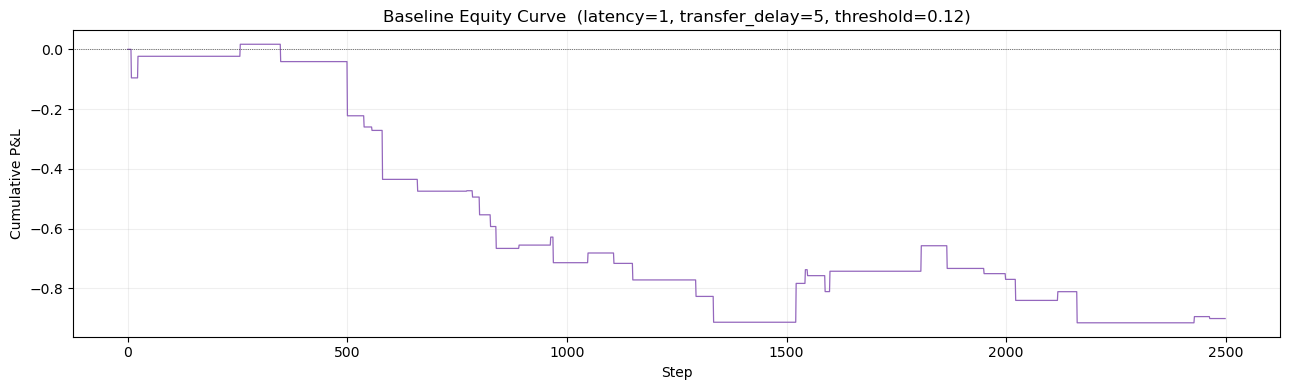

In [5]:
baseline = run_latency_arb(
    latency_steps  = baseline_latency,
    transfer_delay = baseline_transfer_delay,
    threshold      = arb_threshold,
)

print('=== Baseline Latency-Arb Summary ===')
print(f'  latency (steps)   : {baseline_latency}')
print(f'  transfer delay    : {baseline_transfer_delay}')
print(f'  threshold         : {arb_threshold}')
print(f'  trades            : {baseline["trades"]}')
print(f'  win_rate          : {baseline["win_rate"]*100:.1f}%')
print(f'  wins / losses     : {baseline["wins"]} / {baseline["losses"]}')
print(f'  final_pnl         : {baseline["final_pnl"]:+.4f}')
print(f'  sharpe (ann.)     : {baseline["sharpe"]:+.3f}')

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(baseline['pnl_path'], color='tab:purple', lw=0.9)
ax.axhline(0, color='black', lw=0.5, linestyle=':')
ax.set_title(
    f'Baseline Equity Curve  (latency={baseline_latency}, '
    f'transfer_delay={baseline_transfer_delay}, threshold={arb_threshold})'
)
ax.set_xlabel('Step')
ax.set_ylabel('Cumulative P&L')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 4) Stress grid: PnL heatmap over latency × transfer delay

### Interpreting the heatmap

The heatmap sweeps the two most critical operational parameters simultaneously.

**Expected patterns:**

| Region | Interpretation |
|--------|---------------|
| Top-left (low latency, low delay) | Maximum edge: fast execution, frequent re-entry |
| Moving right (higher delay) | Opportunity cost rises; same trades but fewer of them |
| Moving up (higher latency) | Edge decays because prices converge before we fill; more adverse fills |
| Bottom-right (high latency, high delay) | Double penalty: slow and infrequent — often loss-making |

**Key insight — the latency cliff:** there is often a sharp transition around a specific latency level where win rate drops below 50% and the strategy flips from profit to loss. This is the **latency budget** — the maximum allowable round-trip time for this strategy to remain viable.

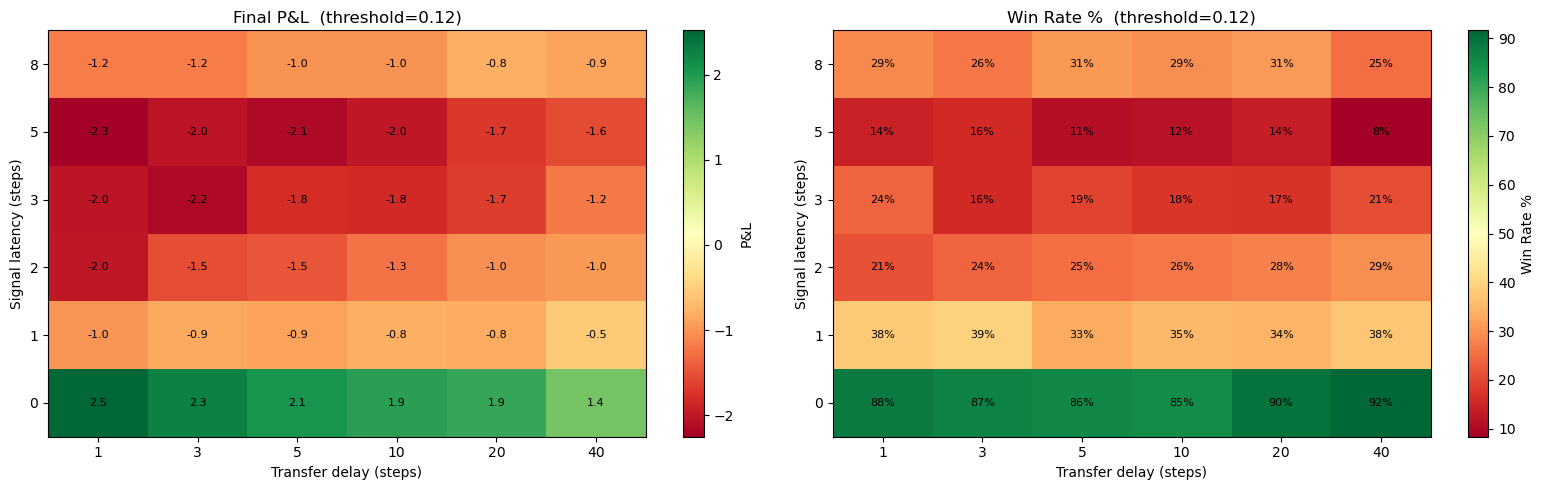

In [6]:
# Build full grid (PnL and win-rate)
pnl_heat  = []
wr_heat   = []

for L in LATENCIES:
    pnl_row = []
    wr_row  = []
    for D in DELAYS:
        res = run_latency_arb(latency_steps=L, transfer_delay=D, threshold=arb_threshold)
        pnl_row.append(res['final_pnl'])
        wr_row.append(res['win_rate'] * 100)
    pnl_heat.append(pnl_row)
    wr_heat.append(wr_row)

def annotated_heatmap(ax, data, row_labels, col_labels, fmt, title, cbar_label):
    im = ax.imshow(data, aspect='auto', origin='lower',
                   cmap='RdYlGn')
    ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels)
    ax.set_yticks(range(len(row_labels))); ax.set_yticklabels(row_labels)
    ax.set_xlabel('Transfer delay (steps)')
    ax.set_ylabel('Signal latency (steps)')
    ax.set_title(title)
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            ax.text(j, i, fmt.format(data[i][j]),
                    ha='center', va='center', fontsize=8,
                    color='black')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)
    return im

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
annotated_heatmap(axes[0], pnl_heat, LATENCIES, DELAYS,
                  '{:.1f}', f'Final P&L  (threshold={arb_threshold})', 'P&L')
annotated_heatmap(axes[1], wr_heat,  LATENCIES, DELAYS,
                  '{:.0f}%', f'Win Rate %  (threshold={arb_threshold})', 'Win Rate %')
plt.tight_layout()
plt.show()

## 5) One-dimensional slices and threshold sensitivity

### Latency and delay slices

Fixing one friction at a time isolates its individual impact:

- **PnL vs. latency** (fixed delay): shows the latency cliff directly. The slope tells you the value of each millisecond of latency reduction — important for infrastructure investment decisions.
- **PnL vs. transfer delay** (fixed latency): shows opportunity cost. Each additional cooldown step reduces the number of trades; if the strategy is profitable on average, more trades means more P&L.

### Threshold sensitivity

A higher threshold means:
- Fewer but higher-quality signals (larger initial price discrepancy)
- More time for the spread to converge before the position must be exited
- Less sensitivity to noise and latency (the signal is stronger)

A lower threshold means:
- More signals, but many will be false positives that reverse before filling
- Higher transaction-cost drag (same fee per trade, more trades)
- More vulnerable to latency: a 1-step delay can erase a small-spread trade entirely

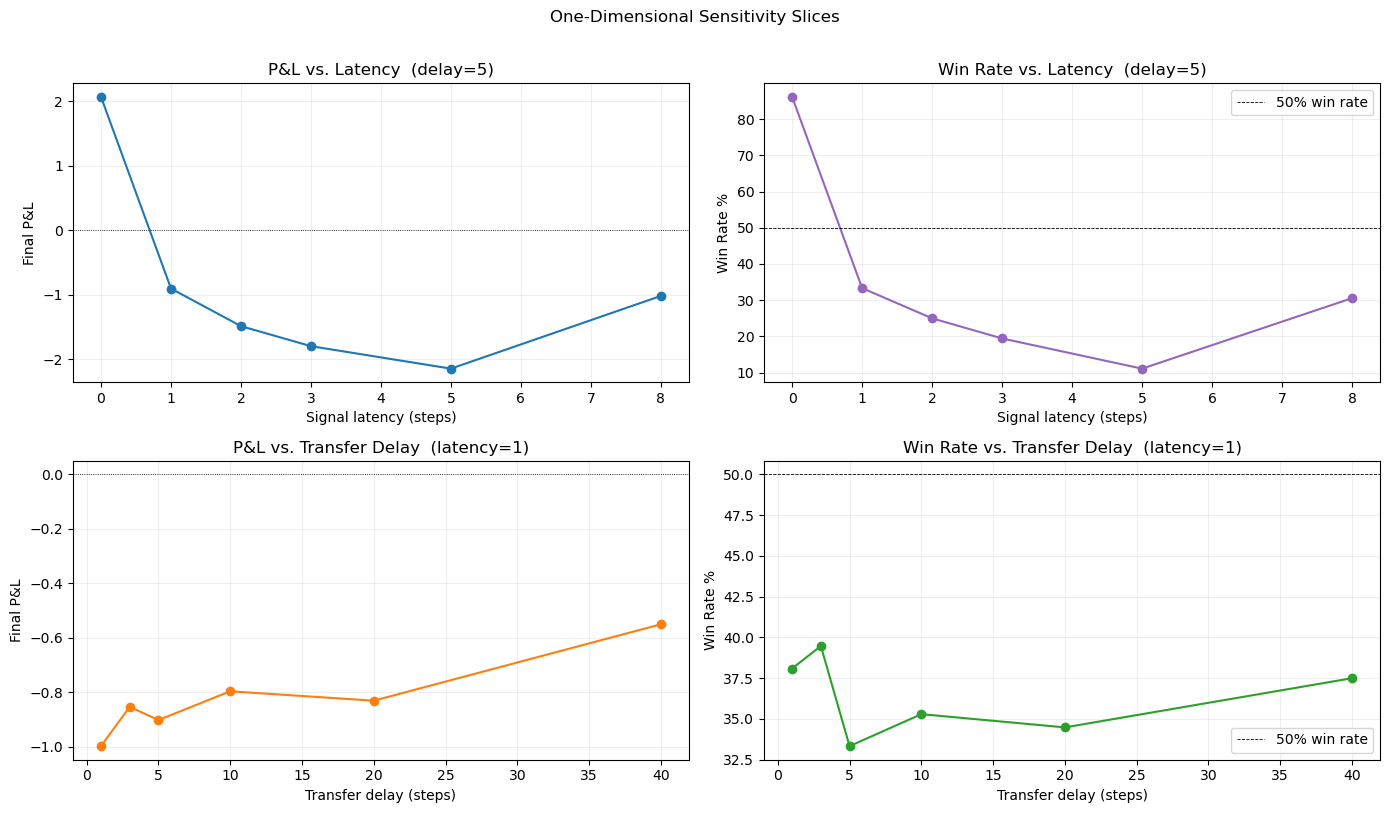


   Threshold  Trades   Win Rate    Net PnL   Sharpe
----------------------------------------------------
        0.06      290       29.3%     -10.987   -126.22
        0.08      179       25.1%      -7.532   -111.36
        0.10       98       28.6%      -3.504    -72.73
        0.12       36       33.3%      -0.901    -31.28
        0.16        6       16.7%      -0.239    -28.98
        0.20        2       50.0%      -0.032    -12.32


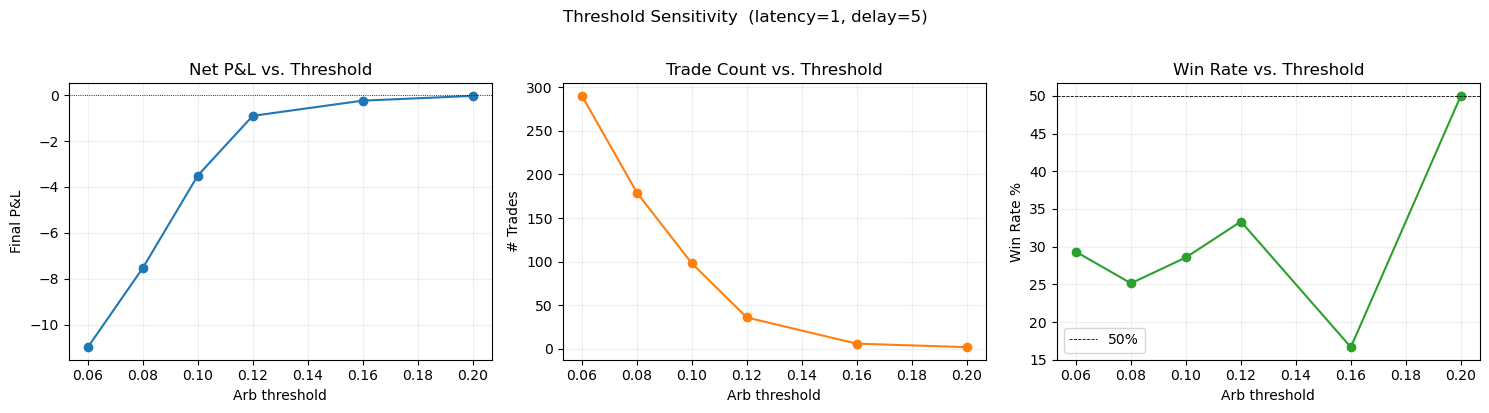

In [7]:
# ── 1-D slices ─────────────────────────────────────────────────────────────
fixed_delay   = baseline_transfer_delay
fixed_latency = baseline_latency

pnl_vs_lat = [run_latency_arb(L, fixed_delay, arb_threshold)['final_pnl']  for L in LATENCIES]
wr_vs_lat  = [run_latency_arb(L, fixed_delay, arb_threshold)['win_rate']*100 for L in LATENCIES]
pnl_vs_del = [run_latency_arb(fixed_latency, D, arb_threshold)['final_pnl'] for D in DELAYS]
wr_vs_del  = [run_latency_arb(fixed_latency, D, arb_threshold)['win_rate']*100 for D in DELAYS]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0,0].plot(LATENCIES, pnl_vs_lat, marker='o', color='tab:blue')
axes[0,0].axhline(0, color='black', lw=0.6, linestyle=':')
axes[0,0].set_title(f'P&L vs. Latency  (delay={fixed_delay})')
axes[0,0].set_xlabel('Signal latency (steps)')
axes[0,0].set_ylabel('Final P&L')
axes[0,0].grid(alpha=0.2)

axes[0,1].plot(LATENCIES, wr_vs_lat, marker='o', color='tab:purple')
axes[0,1].axhline(50, color='black', lw=0.6, linestyle='--', label='50% win rate')
axes[0,1].set_title(f'Win Rate vs. Latency  (delay={fixed_delay})')
axes[0,1].set_xlabel('Signal latency (steps)')
axes[0,1].set_ylabel('Win Rate %')
axes[0,1].legend()
axes[0,1].grid(alpha=0.2)

axes[1,0].plot(DELAYS, pnl_vs_del, marker='o', color='tab:orange')
axes[1,0].axhline(0, color='black', lw=0.6, linestyle=':')
axes[1,0].set_title(f'P&L vs. Transfer Delay  (latency={fixed_latency})')
axes[1,0].set_xlabel('Transfer delay (steps)')
axes[1,0].set_ylabel('Final P&L')
axes[1,0].grid(alpha=0.2)

axes[1,1].plot(DELAYS, wr_vs_del, marker='o', color='tab:green')
axes[1,1].axhline(50, color='black', lw=0.6, linestyle='--', label='50% win rate')
axes[1,1].set_title(f'Win Rate vs. Transfer Delay  (latency={fixed_latency})')
axes[1,1].set_xlabel('Transfer delay (steps)')
axes[1,1].set_ylabel('Win Rate %')
axes[1,1].legend()
axes[1,1].grid(alpha=0.2)

plt.suptitle('One-Dimensional Sensitivity Slices', y=1.01)
plt.tight_layout()
plt.show()

# ── Threshold sensitivity (fixed latency and delay) ─────────────────────────
thr_results = {
    thr: run_latency_arb(baseline_latency, baseline_transfer_delay, thr)
    for thr in THRESHOLDS
}

print(f"\n{'Threshold':>12s} {'Trades':>7s} {'Win Rate':>10s} {'Net PnL':>10s} {'Sharpe':>8s}")
print('-' * 52)
for thr, res in thr_results.items():
    print(f"  {thr:>10.2f}   {res['trades']:>6d}   {res['win_rate']*100:>8.1f}%"
          f"   {res['final_pnl']:>+9.3f}   {res['sharpe']:>+7.2f}")

fig2, axes2 = plt.subplots(1, 3, figsize=(15, 4))
thrs = list(THRESHOLDS)

axes2[0].plot(thrs, [thr_results[t]['final_pnl'] for t in thrs], marker='o', color='tab:blue')
axes2[0].axhline(0, color='black', lw=0.6, linestyle=':')
axes2[0].set_title('Net P&L vs. Threshold')
axes2[0].set_xlabel('Arb threshold')
axes2[0].set_ylabel('Final P&L')
axes2[0].grid(alpha=0.2)

axes2[1].plot(thrs, [thr_results[t]['trades'] for t in thrs], marker='o', color='tab:orange')
axes2[1].set_title('Trade Count vs. Threshold')
axes2[1].set_xlabel('Arb threshold')
axes2[1].set_ylabel('# Trades')
axes2[1].grid(alpha=0.2)

axes2[2].plot(thrs, [thr_results[t]['win_rate']*100 for t in thrs], marker='o', color='tab:green')
axes2[2].axhline(50, color='black', lw=0.6, linestyle='--', label='50%')
axes2[2].set_title('Win Rate vs. Threshold')
axes2[2].set_xlabel('Arb threshold')
axes2[2].set_ylabel('Win Rate %')
axes2[2].legend()
axes2[2].grid(alpha=0.2)

plt.suptitle(f'Threshold Sensitivity  (latency={baseline_latency}, delay={baseline_transfer_delay})', y=1.02)
plt.tight_layout()
plt.show()

## Caveats and model scope

### What this model captures
- The qualitative impact of latency and transfer delay on cross-venue arb profitability
- The latency cliff: the point where edge flips sign as execution lag exceeds convergence speed
- The threshold trade-off: signal selectivity vs. trade frequency vs. cost drag
- Win-rate as a complementary diagnostic to P&L (a strategy can be net profitable with < 50% win rate if wins are larger than losses)

### What is intentionally simplified

| Simplification | Real-world complication |
|---------------|------------------------|
| One-step exit (hold for exactly 1 step after fill) | Optimal holding period depends on convergence speed; could use a dynamic exit signal |
| Simultaneous fills on both legs | In reality, one leg fills first; the other may fill at a worse price or not at all (**leg risk**) |
| Fixed `qty = 1.0` | Real strategies size based on available liquidity, spread width, and risk limits |
| No queue model | First-in-first-out priority queues mean latency affects fill probability, not just fill price |
| Symmetric venues | Real venues differ in maker/taker fee structure, minimum order size, and API reliability |
| Single threshold | Production systems use dynamic thresholds calibrated to current volatility |

### Interpreting results in an interview context

- **If P&L > 0 at latency=0**: the strategy has an exploitable edge assuming perfect execution. This is the theoretical upper bound.
- **The latency at which P&L crosses zero**: this is the maximum allowable round-trip time. Any infrastructure with latency above this is unviable for this strategy.
- **If P&L < 0 for all latencies**: the threshold may be too low (signal too noisy) or the basis is too mean-reverting to exploit profitably (it reverts before fills occur).

### Extensions to try
- Replace one-step exit with a **convergence-based exit**: hold until `|B − A| < exit_threshold`
- Add **leg risk**: with probability `p_fail`, one leg fills but the other does not — you are left with a naked directional position
- Model **queue position**: fill probability decays as a function of latency, rather than fill being guaranteed
- Run a 3D sweep over `(latency, delay, threshold)` and visualise the profitable region as an isosurface